## Installs and Imports

In [1]:
%%capture
!pip install tqdm pyLDAvis gensim numpy bokeh contractions
!conda install -c conda-forge huggingface_hub -y

In [101]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [734]:
import base64
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 0)
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import datapane as dp

## Data Acquisition via Gmail API

In [ ]:
from quickstart import get_service, get_data
service = get_service()
messages = get_data(service, 'Medium Daily Digest')

In [ ]:
print(len(messages))

In [ ]:
print(messages[0])

In [ ]:
# experimenting with a single message
message = messages[0]
msg = service.users().messages().get(userId='me', id=message['id'], format='full').execute()
print(msg.keys())

In [ ]:
print(msg['snippet'])

In [ ]:
print(msg['payload']['parts'][0]['body']['data'][:200])

In [ ]:
content = msg['payload']['parts'][0]['body']['data']
msg_body = base64.urlsafe_b64decode(content).decode('utf-8')
print(msg_body[:1500])

In [ ]:
text = re.sub(r'\(https?:\S+.*\)', '', msg_body, flags=re.MULTILINE).strip('\r')
re.findall('(.*)\r\n\r\n(.*)\r\n\r\n(.*) \r\n in (.*)\r\n*·(.*) min read', text, re.MULTILINE)[:5]

### Regex Parsing of HTML Text

In [ ]:
def parse_email_digest(date, msg_body):
    """ Returns a list of article information
        title, subtitle, author, publication, minutes (reading time)"""
    
    text = re.sub(r'\(https?:\S+.*\)', '', msg_body, flags=re.MULTILINE).strip('\r')
    articles = [list(match) for match in re.findall('(.*)\r\n\r\n(.*)\r\n\r\n(.*) \r\n in (.*)\r\n*·(.*) min read', text, re.MULTILINE)]
    
    # workaround for old email Medium Daily Digest format prior to March 23, 2021
    if len(articles) == 0:
        articles = [list(match) for match in re.findall('(.*)\r\n\r\n(.*)\r\n(.*) \r\n\ in (.*)\r\n(.*) min read', text, re.MULTILINE)]
    return articles

data = []
num_articles_fetched = []
for message in tqdm(messages):
    
    # Get an email by id
    msg = service.users().messages().get(userId='me', id=message['id'], format='full').execute()
    
    # Get date of email for the purpose of topic modeling over time
    for date_dict in msg['payload']['headers']:
        if date_dict['name'] == 'Date':
            date = date_dict['value']
    date = pd.to_datetime(date)

    # Get the email body and decode it from UTF-8
    content = msg['payload']['parts'][0]['body']['data']
    msg_body = base64.urlsafe_b64decode(content).decode('utf-8')
    
    # Extract article information for all articles featured in daily digest
    fetched_articles = parse_email_digest(date, msg_body)
    num_articles_fetched.append(len(fetched_articles))
    for articles in fetched_articles:
        data.append([date, *articles])


In [ ]:
for entry in data[:3]:
    print(entry)

In [ ]:
# TROUBLESHOOT HERE
# identify all zero articles fetched digest emails
message = messages[num_articles_fetched.index(0)]
msg = service.users().messages().get(userId='me', id=message['id'], format='full').execute()
for date_dict in msg['payload']['headers']:
    if date_dict['name'] == 'Date':
        date = date_dict['value']
date = pd.to_datetime(date)
content = msg['payload']['parts'][0]['body']['data']
msg_body = base64.urlsafe_b64decode(content).decode('utf-8')
text = re.sub(r'\(https?:\S+.*\)', '', msg_body, flags=re.MULTILINE).strip('\r')
# print(text)

In [ ]:
df = pd.DataFrame(data, columns = ['Date', 'Title', 'Subtitle', 'Author', 'Publication', 'Minutes'])
df['Minutes'] = df['Minutes'].astype(int)
df.to_csv('raw_data/article_data_via_gmail_api.csv', index=False)
df

## Load Data from CSV

In [707]:
df = pd.read_csv('https://raw.githubusercontent.com/sejaldua/digesting-the-digest/main/raw_data/article_data_via_gmail_api.csv')
df[['Title', 'Subtitle']] = df[['Title', 'Subtitle']].astype('string')
df = df.drop_duplicates(subset=['Title', 'Subtitle'], keep='first', ignore_index=True)
df

,Date,Title,Subtitle,Author,Publication,Minutes
0,2021-08-30 11:40:00+00:00,Towards Better Data Visualizations and Graphics,Design principles for creating data-based graphics and visuals,Prashant Mudgal,Towards Data Science,5
1,2021-08-30 11:40:00+00:00,Making Sense of 33 Million Rows of Instacart Data: Exploratory Data Analysis…,Instacart is one of the hottest Silicon Valley startups of the last decade and is now valued at whopping $39…,Vijay Vankayalapati,Geek Culture,6
2,2021-08-30 11:40:00+00:00,Data Science Learning Path with Python,"I often receive messages from new members of Jakarta AI Research Discord Server, ""where do I start to learn…",Andreas Chandra,Data Folks Indonesia,3
3,2021-08-30 11:40:00+00:00,Jupyter Notebook can do that?,Soup up your cells with a couple of key extensions,Jesse Markowitz,CodeX,5
4,2021-08-30 11:40:00+00:00,Reshaping Mitochondria to Reverse Obesity,Changing the shape of mitochondria can reverse some of the molecular processes underlying obesity (in mice),Gunnar De Winter,In Fitness And In Health,4
...,...,...,...,...,...,...
7062,2020-01-01 16:30:00+00:00,How to Get the Unquantifiable Benefits of Cold Showers,The surprising side effects that science can't measure and money can't buy,May Pang,Better Humans,10
7063,2020-01-01 16:30:00+00:00,Screw Productivity Hacks: My Morning Routine Is Getting up Late,Anyone who brags about a 3:30 a.m. gym routine is sending a clear signal: Time is a thing to be optimized…,Jessica Valenti,GEN,3
7064,2020-01-01 16:30:00+00:00,The Latest Science on Chronic Pain Is Fascinating,"Experts can even predict who's likely to suffer or recover, based on brain structure and personality",Robert Roy Britt,Elemental,14
7065,2020-01-01 16:30:00+00:00,5 scientific myths you probably believe about the Universe,How a little knowledge can bring about some huge misconceptions… and how to fix it.,Ethan Siegel,Starts With A Bang!,8


In [735]:
dp.DataTable(df)

## Quick Exploratory Visualizations

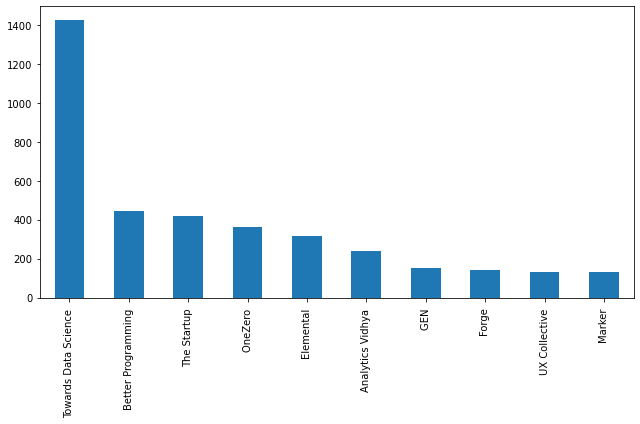

In [708]:
fig = plt.figure(figsize=(9,6))
df['Publication'].value_counts().iloc[:10].plot.bar();
plt.tight_layout();
fig.savefig('./figures/publication_counts.png')

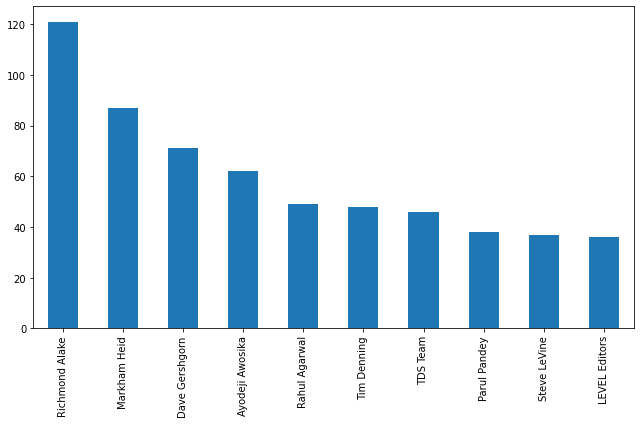

In [709]:
fig = plt.figure(figsize=(9,6))
df['Author'].value_counts().iloc[:10].plot.bar();
plt.tight_layout();
fig.savefig('./figures/author_counts.png')

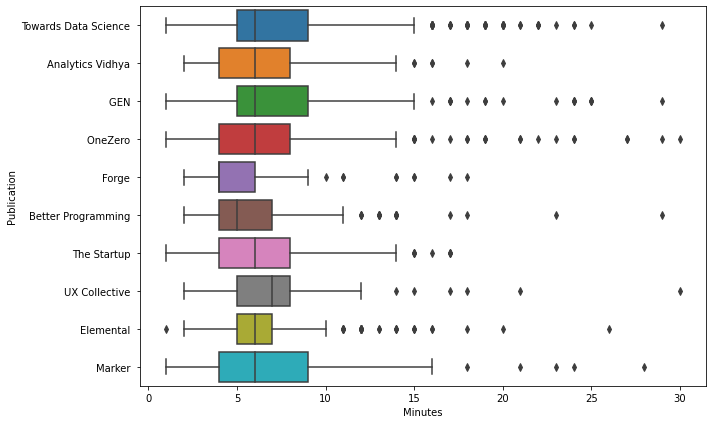

In [710]:
import seaborn as sns
fig = plt.figure(figsize=(10,6))
sns.boxplot(data=df[(df['Minutes'] <= 30) & (df['Publication'].isin(df['Publication'].value_counts().iloc[:10].index))], x='Minutes', y='Publication')
plt.tight_layout()
fig.savefig('./figures/minutes_publication_boxplot.png')

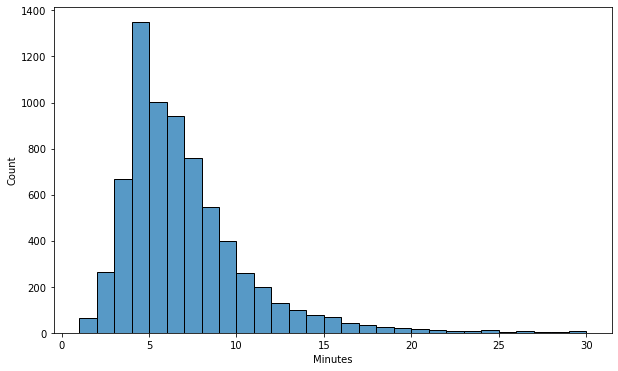

In [711]:
import seaborn as sns
fig = plt.figure(figsize=(10,6))
sns.histplot(data=df[(df['Minutes'] <= 30)], x='Minutes', binwidth=1)
fig.savefig('./figures/minutes_distribution.png')

## Cleaning & Preprocessing

In [712]:
# Gensim and LDA
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

# NLP stuff
import contractions
import demoji
import string
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
nltk.download('wordnet')
import spacy

# Plotting tools
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
%matplotlib inline

# Miscellaneous
from sklearn.manifold import TSNE
from pprint import pprint

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sejaldua/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [713]:
df['text'] = df[['Title', 'Subtitle']].agg(' '.join, axis=1)
df

,Date,Title,Subtitle,Author,Publication,Minutes,text
0,2021-08-30 11:40:00+00:00,Towards Better Data Visualizations and Graphics,Design principles for creating data-based graphics and visuals,Prashant Mudgal,Towards Data Science,5,Towards Better Data Visualizations and Graphics Design principles for creating data-based graphics and visuals
1,2021-08-30 11:40:00+00:00,Making Sense of 33 Million Rows of Instacart Data: Exploratory Data Analysis…,Instacart is one of the hottest Silicon Valley startups of the last decade and is now valued at whopping $39…,Vijay Vankayalapati,Geek Culture,6,Making Sense of 33 Million Rows of Instacart Data: Exploratory Data Analysis… Instacart is one of the hottest Silicon Valley startups of the last decade and is now valued at whopping $39…
2,2021-08-30 11:40:00+00:00,Data Science Learning Path with Python,"I often receive messages from new members of Jakarta AI Research Discord Server, ""where do I start to learn…",Andreas Chandra,Data Folks Indonesia,3,"Data Science Learning Path with Python I often receive messages from new members of Jakarta AI Research Discord Server, ""where do I start to learn…"
3,2021-08-30 11:40:00+00:00,Jupyter Notebook can do that?,Soup up your cells with a couple of key extensions,Jesse Markowitz,CodeX,5,Jupyter Notebook can do that? Soup up your cells with a couple of key extensions
4,2021-08-30 11:40:00+00:00,Reshaping Mitochondria to Reverse Obesity,Changing the shape of mitochondria can reverse some of the molecular processes underlying obesity (in mice),Gunnar De Winter,In Fitness And In Health,4,Reshaping Mitochondria to Reverse Obesity Changing the shape of mitochondria can reverse some of the molecular processes underlying obesity (in mice)
...,...,...,...,...,...,...,...
7062,2020-01-01 16:30:00+00:00,How to Get the Unquantifiable Benefits of Cold Showers,The surprising side effects that science can't measure and money can't buy,May Pang,Better Humans,10,How to Get the Unquantifiable Benefits of Cold Showers The surprising side effects that science can't measure and money can't buy
7063,2020-01-01 16:30:00+00:00,Screw Productivity Hacks: My Morning Routine Is Getting up Late,Anyone who brags about a 3:30 a.m. gym routine is sending a clear signal: Time is a thing to be optimized…,Jessica Valenti,GEN,3,Screw Productivity Hacks: My Morning Routine Is Getting up Late Anyone who brags about a 3:30 a.m. gym routine is sending a clear signal: Time is a thing to be optimized…
7064,2020-01-01 16:30:00+00:00,The Latest Science on Chronic Pain Is Fascinating,"Experts can even predict who's likely to suffer or recover, based on brain structure and personality",Robert Roy Britt,Elemental,14,"The Latest Science on Chronic Pain Is Fascinating Experts can even predict who's likely to suffer or recover, based on brain structure and personality"
7065,2020-01-01 16:30:00+00:00,5 scientific myths you probably believe about the Universe,How a little knowledge can bring about some huge misconceptions… and how to fix it.,Ethan Siegel,Starts With A Bang!,8,5 scientific myths you probably believe about the Universe How a little knowledge can bring about some huge misconceptions… and how to fix it.


In [714]:
def preprocess(text_col):
    
    # convert to lowercase
    text_col = text_col.apply(lambda x: ' '.join([w.lower() for w in x.split()]))
    
    # remove emojis
    text_col = text_col.apply(lambda x: demoji.replace(x, ""))
    
    # fix contractions  
    text_col = text_col.apply(lambda x: ' '.join([contractions.fix(word) for word in x.split()]))

    # remove punctuation
    text_col = text_col.apply(lambda x: ''.join([i for i in x if i not in string.punctuation]))
    
    # remove numbers
    text_col = text_col.apply(lambda x: ' '.join(re.sub("[^a-zA-Z]+", " ", x).split()))

    # remove stopwords
    stopwords = [sw for sw in nltk.corpus.stopwords.words('english') if sw not in ['not', 'no']]
    text_col = text_col.apply(lambda x: ' '.join([w for w in x.split() if w not in stopwords]))

    # lemmatization
    text_col = text_col.apply(lambda x: ' '.join([WordNetLemmatizer().lemmatize(w) for w in x.split()]))

    # remove short words
    text_col = text_col.apply(lambda x: ' '.join([w.strip() for w in x.split() if len(w.strip()) >= 3]))

    return text_col

df['text'] = preprocess(df['text'])
df.rename(columns={'Date': 'date'}, inplace=True)
df[['date', 'text']].to_csv('medium-suggested-cleaned.csv', index=False)
print(*df['text'].head(20).values, sep='\n')

towards better data visualization graphic design principle creating databased graphic visuals
making sense million row instacart data exploratory data analysis instacart one hottest silicon valley startup last decade valued whopping
data science learning path python often receive message new member jakarta research discord server start learn
jupyter notebook soup cell couple key extension
reshaping mitochondrion reverse obesity changing shape mitochondrion reverse molecular process underlying obesity mouse
data type data science quick guide difference quantitative qualitative data
reducing product stockouts hypermarket time series modeling pragmatic guide creating data science product limited data high business constraint
summarize article using nlp summarize text using simple technique
tim ferriss system mastering skill pure genius method world successful human guinea pig
datasets need practice data science skill make great great collection different kind datasets
python package moder

## Wordcloud

In [715]:
all_words = ' '.join(df['text'].values).split()
all_words[:20]

['towards',
 'better',
 'data',
 'visualization',
 'graphic',
 'design',
 'principle',
 'creating',
 'databased',
 'graphic',
 'visuals',
 'making',
 'sense',
 'million',
 'row',
 'instacart',
 'data',
 'exploratory',
 'data',
 'analysis']

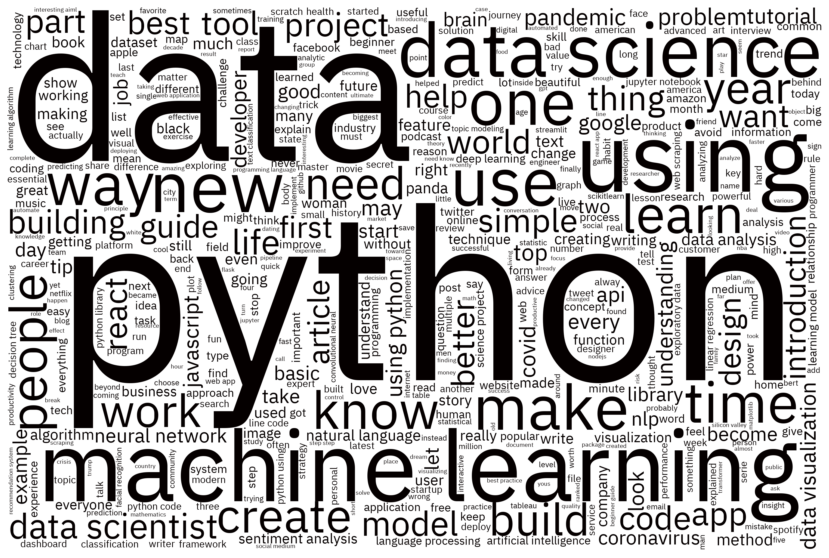

In [716]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")

wordcloud = WordCloud(font_path = '~/Library/Fonts/IBMPlexSans-Regular.ttf', 
                      background_color="white", width=3000, height=2000, collocations=True,
                      max_words=500, stopwords=STOPWORDS).generate_from_text(' '.join(df['text'].values))

# set the word color to black
wordcloud.recolor(color_func = black_color_func)
fig = plt.figure(figsize=[15,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
fig.savefig('./figures/wordcloud.png')

## Topic Modeling Prep

### Data Preprocessing

In [717]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence).encode('utf-8'), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df['text'].tolist()))
print(data_words[:1])
print("Total docs:", len(data_words))

[['towards', 'better', 'data', 'visualization', 'graphic', 'design', 'principle', 'creating', 'databased', 'graphic', 'visuals']]
Total docs: 7067


In [718]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [719]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [720]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['well', 'graphic', 'design', 'principle', 'create', 'database', 'graphic', 'visual']]


### Dictionary & Corpus

In [721]:
# Create dictionary and corpus needed for topic modeling

# dictionary is a mapping of word_id --> word, as the variable name implies
id2word = corpora.Dictionary(data_lemmatized)
id2word.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

# the preprocessed and lemmatized documents themselves
texts = data_lemmatized

# corpus is a mapping of word_id --> word frequency
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]]


In [722]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('create', 1),
  ('database', 1),
  ('design', 1),
  ('principle', 1),
  ('visual', 1),
  ('well', 1)]]

## Latent Dirichlet Allocation (LDA)

In [723]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [724]:
# Print the Keyword in the 10 topics
pprint(lda_model.show_topics(formatted=False)[:5])
doc_lda = lda_model[corpus]

[(0,
  [('datum', 0.10501622),
   ('science', 0.072926536),
   ('design', 0.0471042),
   ('well', 0.039622),
   ('data', 0.03882656),
   ('habit', 0.03297718),
   ('big', 0.029455421),
   ('say', 0.028539743),
   ('right', 0.026664821),
   ('look', 0.025064476)]),
 (1,
  [('change', 0.07063615),
   ('woman', 0.048221927),
   ('let', 0.0432875),
   ('man', 0.032445163),
   ('great', 0.03241318),
   ('find', 0.030587604),
   ('lot', 0.028954819),
   ('different', 0.027227191),
   ('function', 0.025140531),
   ('startup', 0.023701748)]),
 (2,
  [('year', 0.05235751),
   ('world', 0.033551194),
   ('think', 0.03146352),
   ('come', 0.02733944),
   ('skill', 0.026899235),
   ('black', 0.026732774),
   ('keep', 0.025219847),
   ('story', 0.02513162),
   ('live', 0.023418894),
   ('see', 0.021918815)]),
 (3,
  [('get', 0.12151204),
   ('work', 0.10194119),
   ('good', 0.097728655),
   ('really', 0.031008631),
   ('show', 0.029916657),
   ('reason', 0.027194675),
   ('advice', 0.02428602),
   

### Model Evaluation Metrics

In [725]:
from gensim.models import CoherenceModel

# Compute Perplexity (lower is better)
print('Perplexity: ', round(lda_model.log_perplexity(corpus), 2))

# Compute Coherence Score (higher is better)
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', round(coherence_lda, 2))

Perplexity:  -6.48
Coherence Score:  0.38


### Visualize Keywords

In [726]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
import os

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(lda_model.num_topics))
viz_prep = True
if viz_prep:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
else:
    # load the pre-prepared pyLDAvis data from disk
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(lda_model.num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.436830  0.057821  1       1        17.538027
0      0.133570  0.418008  2       1        12.766575
8      0.069035 -0.113635  3       1        12.144978
2      0.109436 -0.165192  4       1        10.213407
7      0.030817 -0.067797  5       1        9.499068 
5      0.023281 -0.027488  6       1        8.517719 
4      0.028948 -0.033235  7       1        8.008676 
6      0.011950 -0.021185  8       1        7.520010 
3      0.015434 -0.027218  9       1        7.228631 
1      0.014359 -0.020080  10      1        6.562910 , topic_info=            Term         Freq        Total Category  logprob  loglift
45   use          1075.000000  1075.000000  Default  30.0000  30.0000
17   learn        592.000000   592.000000   Default  29.0000  29.0000
8    datum        654.000000   654.000000   Default  28.0000  28.0000
87   get          429.000000   429.000000   Default  27.0000  27.0000
13   make         645.000000   645.000000   Default  26.0000  26.0000
..    ...                ...          ...       ...      ...      ...
615  wrong        37.610388    38.534300    Topic10 -4.4441   2.6995 
332  environment  37.373960    38.297964    Topic10 -4.4504   2.6993 
57   kind         37.113447    38.037479    Topic10 -4.4574   2.6991 
608  plan         37.008334    37.932342    Topic10 -4.4602   2.6991 
11   hot          36.617696    37.541847    Topic10 -4.4708   2.6988 

[330 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
497   6      0.986398  accord  
302   7      0.992371  actually
602   9      0.993403  advice  
457   2      0.990570  also    
770   6      0.987485  amazon  
...  ..           ...   ...    
52    4      0.993507  world   
75    7      0.994673  write   
301   8      0.987028  writer  
615   10     0.986134  wrong   
102   4      0.996988  year    

[300 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 1, 9, 3, 8, 6, 5, 7, 4, 2])

### Finding the most dominant topic in each sentence

In [727]:
def get_dominant_topics(ldamodel=lda_model, corpus=corpus, texts=texts):
    sent_topics_df = pd.DataFrame()

    # Get dominant topic in each document and the probability associated with it
    for i, row in enumerate(ldamodel[corpus]):
        try:
            row = sorted(row, key=lambda x: (x[1]), reverse=True)
        except:
            row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        dom_topic = row[0]
        topic_num, topic_proba = dom_topic
        sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(topic_proba,4)]), ignore_index=True)
    sent_topics_df.columns = ['Dominant_Topic', 'Topic_Proba']
    sent_topics_df['Dominant_Topic'] = sent_topics_df['Dominant_Topic'].astype(int)
    return(sent_topics_df)

df_with_topics = get_dominant_topics(ldamodel=lda_model, corpus=corpus, texts=texts)
lda_df = pd.concat([df, df_with_topics], axis=1)
lda_df

,date,Title,Subtitle,Author,Publication,Minutes,text,Dominant_Topic,Topic_Proba
0,2021-08-30 11:40:00+00:00,Towards Better Data Visualizations and Graphics,Design principles for creating data-based graphics and visuals,Prashant Mudgal,Towards Data Science,5,towards better data visualization graphic design principle creating databased graphic visuals,0,0.2739
1,2021-08-30 11:40:00+00:00,Making Sense of 33 Million Rows of Instacart Data: Exploratory Data Analysis…,Instacart is one of the hottest Silicon Valley startups of the last decade and is now valued at whopping $39…,Vijay Vankayalapati,Geek Culture,6,making sense million row instacart data exploratory data analysis instacart one hottest silicon valley startup last decade valued whopping,1,0.2646
2,2021-08-30 11:40:00+00:00,Data Science Learning Path with Python,"I often receive messages from new members of Jakarta AI Research Discord Server, ""where do I start to learn…",Andreas Chandra,Data Folks Indonesia,3,data science learning path python often receive message new member jakarta research discord server start learn,0,0.1594
3,2021-08-30 11:40:00+00:00,Jupyter Notebook can do that?,Soup up your cells with a couple of key extensions,Jesse Markowitz,CodeX,5,jupyter notebook soup cell couple key extension,2,0.2079
4,2021-08-30 11:40:00+00:00,Reshaping Mitochondria to Reverse Obesity,Changing the shape of mitochondria can reverse some of the molecular processes underlying obesity (in mice),Gunnar De Winter,In Fitness And In Health,4,reshaping mitochondrion reverse obesity changing shape mitochondrion reverse molecular process underlying obesity mouse,1,0.1635
...,...,...,...,...,...,...,...,...,...
7062,2020-01-01 16:30:00+00:00,How to Get the Unquantifiable Benefits of Cold Showers,The surprising side effects that science can't measure and money can't buy,May Pang,Better Humans,10,get unquantifiable benefit cold shower surprising side effect science cannot measure money cannot buy,3,0.1692
7063,2020-01-01 16:30:00+00:00,Screw Productivity Hacks: My Morning Routine Is Getting up Late,Anyone who brags about a 3:30 a.m. gym routine is sending a clear signal: Time is a thing to be optimized…,Jessica Valenti,GEN,3,screw productivity hack morning routine getting late anyone brag gym routine sending clear signal time thing optimized,5,0.1746
7064,2020-01-01 16:30:00+00:00,The Latest Science on Chronic Pain Is Fascinating,"Experts can even predict who's likely to suffer or recover, based on brain structure and personality",Robert Roy Britt,Elemental,14,latest science chronic pain fascinating expert even predict likely suffer recover based brain structure personality,0,0.1922
7065,2020-01-01 16:30:00+00:00,5 scientific myths you probably believe about the Universe,How a little knowledge can bring about some huge misconceptions… and how to fix it.,Ethan Siegel,Starts With A Bang!,8,scientific myth probably believe universe little knowledge bring huge misconception fix,0,0.1922


### Visualization

In [728]:
# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
# arr = arr[np.amax(arr, axis=1) > 0.20]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7067 samples in 0.004s...
[t-SNE] Computed neighbors for 7067 samples in 0.682s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7067
[t-SNE] Computed conditional probabilities for sample 2000 / 7067
[t-SNE] Computed conditional probabilities for sample 3000 / 7067
[t-SNE] Computed conditional probabilities for sample 4000 / 7067
[t-SNE] Computed conditional probabilities for sample 5000 / 7067
[t-SNE] Computed conditional probabilities for sample 6000 / 7067
[t-SNE] Computed conditional probabilities for sample 7000 / 7067
[t-SNE] Computed conditional probabilities for sample 7067 / 7067
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.645050
[t-SNE] KL divergence after 1000 iterations: 2.246212


In [729]:
# Plot the Topic Clusters using Bokeh


from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, HoverTool, CategoricalColorMapper, LinearColorMapper, ColorBar
from bokeh.palettes import plasma
from bokeh.plotting import figure
from bokeh.transform import transform
from bokeh.palettes import d3
from bokeh.palettes import brewer, plasma
from bokeh.palettes import Viridis256, Category10
from bokeh.transform import factor_cmap

list_x = list(tsne_lda[:,0])
list_y = list(tsne_lda[:,1])


source = ColumnDataSource(data=dict(
    x=list_x, 
    y=list_y, 
    topic_num=list(lda_df['Dominant_Topic']),
    title=list(lda_df['Title']),
    subtitle=list(lda_df['Subtitle']),
    proba=[(x * 100) // 10 + 2 for x in list(lda_df['Topic_Proba'])]))
hover = HoverTool(tooltips=[
    ("index", "$index"),
    ('title', '@title'),
    ('subtitle', '@subtitle'),
    ("topic", '@topic_num')
])


mapper = LinearColorMapper(palette='Spectral10', low=min(lda_df['Dominant_Topic'].unique()), high=max(lda_df['Dominant_Topic'].unique()))


p = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
           plot_width=900, plot_height=700, tools=[hover])
p.circle('x', 'y',
         size='proba',
         fill_color={'field': 'topic_num', 'transform': mapper}, 
         line_color={'field': 'topic_num', 'transform': mapper}, 
         source=source)
color_bar = ColorBar(color_mapper=mapper, width=8,  location=(0,0))
p.add_layout(color_bar, 'right')
show(p)

## LDA Mallet Model

In [730]:
mallet_path = '~/Downloads/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [731]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False)[:3])

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()

print('Coherence Score: ', round(coherence_ldamallet, 2))

[(0,
  [('change', 0.03735144312393888),
   ('pandemic', 0.028862478777589132),
   ('day', 0.023769100169779286),
   ('question', 0.022313849138976473),
   ('live', 0.021586223623575068),
   ('long', 0.021101139946640795),
   ('feel', 0.021101139946640795),
   ('end', 0.019888430754305117),
   ('future', 0.019403347077370847),
   ('business', 0.01867572156196944)]),
 (1,
  [('build', 0.09036576619650968),
   ('create', 0.08797513746115228),
   ('react', 0.06359072436050682),
   ('app', 0.055462586660291656),
   ('web', 0.04446569447764762),
   ('application', 0.03179536218025341),
   ('user', 0.02390628735357399),
   ('love', 0.02342816160650251),
   ('woman', 0.02318909873296677),
   ('interactive', 0.01840784126225197)]),
 (2,
  [('datum', 0.2579690346083789),
   ('science', 0.1186247723132969),
   ('data', 0.07923497267759563),
   ('project', 0.05623861566484517),
   ('analysis', 0.05214025500910747),
   ('visualization', 0.04735883424408015),
   ('library', 0.03529143897996357),
  

In [732]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

### Find most optimal number of topics

In [733]:
# NOTE: can take a long time to run...
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=4, limit=40, step=4)

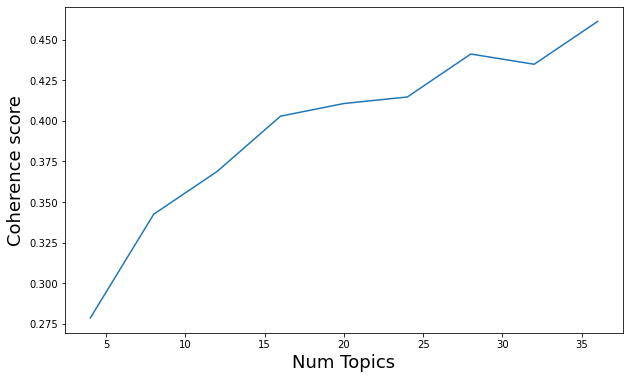

In [492]:
# Graph coherence values vs number of topics
limit=40; start=4; step=4;
x = range(start, limit, step)
fig = plt.figure(figsize=(10,6))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics", fontsize=18)
plt.ylabel("Coherence score", fontsize=18)
plt.grid()
plt.show()

In [493]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 4  has Coherence Value of 0.2787
Num Topics = 8  has Coherence Value of 0.3425
Num Topics = 12  has Coherence Value of 0.3689
Num Topics = 16  has Coherence Value of 0.4029
Num Topics = 20  has Coherence Value of 0.4107
Num Topics = 24  has Coherence Value of 0.4147
Num Topics = 28  has Coherence Value of 0.4412
Num Topics = 32  has Coherence Value of 0.4348
Num Topics = 36  has Coherence Value of 0.4612


In [497]:
# optimal_model = model_list[coherence_values.index(max(coherence_values))]
optimal_model = model_list[-3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(25,
  '0.090*"deep" + 0.070*"brain" + 0.063*"understand" + 0.061*"technique" + '
  '0.044*"high" + 0.043*"learning" + 0.041*"neural_network" + 0.034*"state" + '
  '0.030*"difference" + 0.028*"play"'),
 (0,
  '0.138*"text" + 0.112*"nlp" + 0.099*"classification" + 0.065*"basic" + '
  '0.060*"processing" + 0.055*"natural_language" + 0.042*"task" + '
  '0.041*"implementation" + 0.036*"process" + 0.036*"review"'),
 (22,
  '0.175*"build" + 0.166*"project" + 0.097*"step" + 0.089*"image" + '
  '0.051*"api" + 0.043*"form" + 0.034*"call" + 0.034*"custom" + '
  '0.034*"scratch" + 0.032*"idea"'),
 (21,
  '0.162*"year" + 0.071*"job" + 0.066*"question" + 0.054*"show" + '
  '0.045*"month" + 0.041*"answer" + 0.039*"engineer" + 0.038*"test" + '
  '0.034*"late" + 0.032*"startup"'),
 (7,
  '0.190*"guide" + 0.074*"read" + 0.073*"book" + 0.070*"great" + '
  '0.063*"beginner" + 0.052*"research" + 0.047*"podcast" + 0.041*"master" + '
  '0.035*"complete" + 0.031*"sign"'),
 (16,
  '0.166*"react" + 0.145*"app

### Finding the dominant topic in each sentence

In [498]:
def get_dominant_topics(ldamodel=lda_model, corpus=corpus, texts=texts):
    sent_topics_df = pd.DataFrame()

    # Get dominant topic in each document and the probability associated with it
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        dom_topic = row[0]
        topic_num, topic_proba = dom_topic
        sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(topic_proba,4)]), ignore_index=True)
    sent_topics_df.columns = ['Dominant_Topic', 'Topic_Proba']
    sent_topics_df['Dominant_Topic'] = sent_topics_df['Dominant_Topic'].astype(int)
    return(sent_topics_df)

df_with_mallet_topics = get_dominant_topics(ldamodel=optimal_model, corpus=corpus, texts=texts)
ldamallet_df = pd.concat([df, df_with_mallet_topics], axis=1)
ldamallet_df

,date,Title,Subtitle,Author,Publication,Minutes,text,Dominant_Topic,Topic_Proba
0,2021-08-30 11:40:00+00:00,Towards Better Data Visualizations and Graphics,Design principles for creating data-based graphics and visuals,Prashant Mudgal,Towards Data Science,5,towards better data visualization graphic design principle creating databased graphic visuals,14,0.0688
1,2021-08-30 11:40:00+00:00,Making Sense of 33 Million Rows of Instacart Data: Exploratory Data Analysis…,Instacart is one of the hottest Silicon Valley startups of the last decade and is now valued at whopping $39…,Vijay Vankayalapati,Geek Culture,6,making sense million row instacart data exploratory data analysis instacart one hottest silicon valley startup last decade valued whopping,11,0.0811
2,2021-08-30 11:40:00+00:00,Data Science Learning Path with Python,"I often receive messages from new members of Jakarta AI Research Discord Server, ""where do I start to learn…",Andreas Chandra,Data Folks Indonesia,3,data science learning path python often receive message new member jakarta research discord server start learn,23,0.0684
3,2021-08-30 11:40:00+00:00,Jupyter Notebook can do that?,Soup up your cells with a couple of key extensions,Jesse Markowitz,CodeX,5,jupyter notebook soup cell couple key extension,27,0.0536
4,2021-08-30 11:40:00+00:00,Reshaping Mitochondria to Reverse Obesity,Changing the shape of mitochondria can reverse some of the molecular processes underlying obesity (in mice),Gunnar De Winter,In Fitness And In Health,4,reshaping mitochondrion reverse obesity changing shape mitochondrion reverse molecular process underlying obesity mouse,4,0.0714
...,...,...,...,...,...,...,...,...,...
7062,2020-01-01 16:30:00+00:00,How to Get the Unquantifiable Benefits of Cold Showers,The surprising side effects that science can't measure and money can't buy,May Pang,Better Humans,10,get unquantifiable benefit cold shower surprising side effect science cannot measure money cannot buy,3,0.0653
7063,2020-01-01 16:30:00+00:00,Screw Productivity Hacks: My Morning Routine Is Getting up Late,Anyone who brags about a 3:30 a.m. gym routine is sending a clear signal: Time is a thing to be optimized…,Jessica Valenti,GEN,3,screw productivity hack morning routine getting late anyone brag gym routine sending clear signal time thing optimized,14,0.0653
7064,2020-01-01 16:30:00+00:00,The Latest Science on Chronic Pain Is Fascinating,"Experts can even predict who's likely to suffer or recover, based on brain structure and personality",Robert Roy Britt,Elemental,14,latest science chronic pain fascinating expert even predict likely suffer recover based brain structure personality,21,0.0672
7065,2020-01-01 16:30:00+00:00,5 scientific myths you probably believe about the Universe,How a little knowledge can bring about some huge misconceptions… and how to fix it.,Ethan Siegel,Starts With A Bang!,8,scientific myth probably believe universe little knowledge bring huge misconception fix,25,0.1093


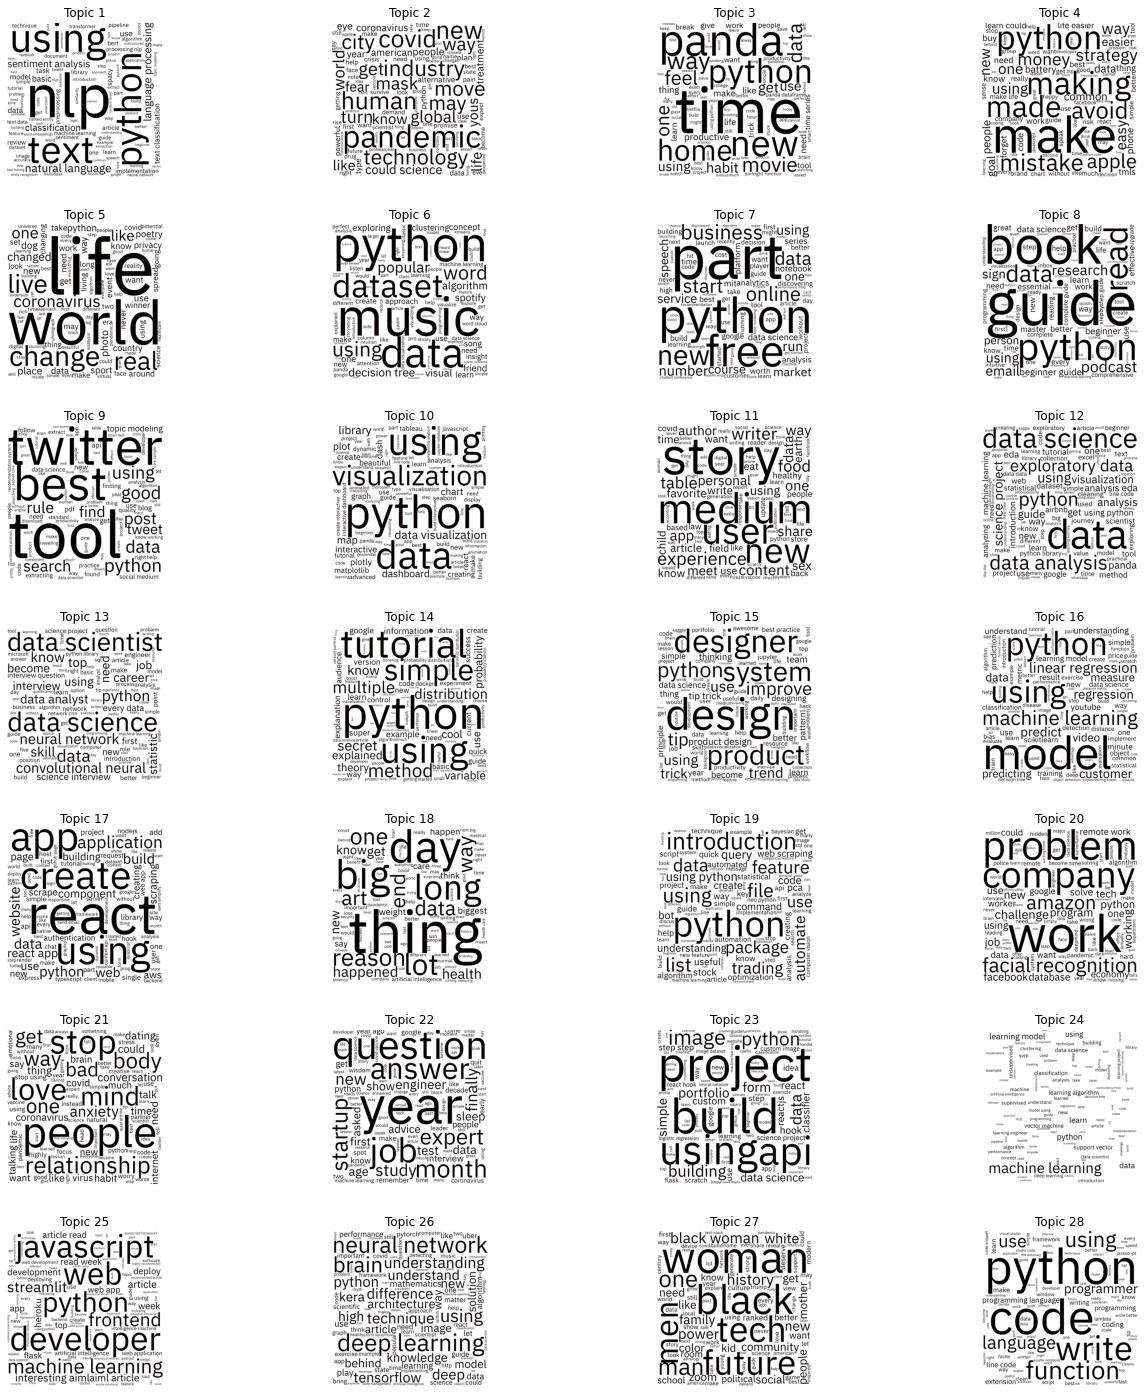

In [499]:
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")

num_topics = optimal_model.num_topics
fig, ax = plt.subplots(num_topics // 4, int(num_topics / (num_topics // 4)), figsize=(20, 20))
for i in range(num_topics):
    text = ' '.join(ldamallet_df.loc[ldamallet_df['Dominant_Topic']==i, 'text'].values)    
    wordcloud = WordCloud(font_path = '~/Library/Fonts/IBMPlexSans-Regular.ttf', 
                      background_color="white", width=2000, height=2000, max_words=100, random_state=42, 
                      collocations=True, stopwords=stop_words, ).generate(text)
    # set the word color to black
    wordcloud.recolor(color_func = black_color_func)
    ax[i // 4, i % 4].imshow(wordcloud) 
    ax[i // 4, i % 4].set_title(f"Topic {i+1}")
    # No axis details
    ax[i // 4, i % 4].axis("off");
    
plt.tight_layout(pad=3);
fig.savefig('figures/topic_wordclouds.png')

### Find the most representative document for each topic

In [500]:
# Group top sentence under each topic
topic_df = pd.DataFrame()
sent_topics_outdf_grpd = ldamallet_df[['Dominant_Topic', 'Topic_Proba', 'text']].groupby('Dominant_Topic')
for i, grp in sent_topics_outdf_grpd:
    topic_df = pd.concat([topic_df, grp.sort_values(['Topic_Proba'], ascending=[0]).head(1)], axis=0)

# Reset Index    
topic_df.reset_index(drop=True, inplace=True)
topic_df['Dominant_Topic'] = topic_df['Dominant_Topic'].astype(int)
topic_df.rename(columns={'Dominant_Topic': 'Topic_Num', 'text': 'Representative Doc'}, inplace=True)

# Get topic keywords
def get_keywords(topic_num):
    wp = optimal_model.show_topic(topic_num)
    topic_keywords = ", ".join([word for word, prop in wp])
    return topic_keywords

topic_df['Keywords'] = topic_df['Topic_Num'].apply(lambda x: get_keywords(x))
topic_df

,Topic_Num,Topic_Proba,Representative Doc,Keywords
0,0,0.1712,building text classification model using bilstm text classification one fundamental task nlp almost every nlp system text classification,"text, nlp, classification, basic, processing, natural_language, task, implementation, process, review"
1,1,0.1170,world powerful supercomputer entered fight ibmbuilt summit found list promising drug covid,"pandemic, industry, human, turn, technology, move, covid, type, powerful, plan"
2,2,0.1238,alltime favorite productivity tool tool gave hour back per day extra hour give time create,"time, panda, feel, give, home, save, habit, break, movie, watch"
3,3,0.1192,common coding mistake avoid mistake many developer make,"make, easy, avoid, apple, strategy, common, mistake, money, buy, risk"
4,4,0.1288,draftkings stayed competitive world without sport investor bullish fantasy sport betting company went public sport casino,"life, world, change, live, real, coronavirus, set, place, open, stay"
5,5,0.1366,profile dataset minute profile dataset quickly mean clustering,"dataset, word, music, explore, popular, approach, concept, algorithm, visualize, friend"
6,6,0.1151,take mit bachelor computer science course free online link free bachelor worth course,"part, start, business, run, online, free, number, series, discover, service"
7,7,0.1112,comprehensive guide grammar graphic effective visualization learn effective strategy leveraging layered grammar graphic framework effective data,"guide, read, book, great, beginner, research, podcast, master, complete, sign"
8,8,0.1677,social medium topic modeling analyze post practice discus way topic modeling used analyze various text post social medium,"good, tool, find, post, search, twitter, extract, rule, tweet, analyze"
9,9,0.1373,dashboard python advanced example dash beginner everyone else code python dashboard learn filter data using dynamic drop list create heatmap add,"visualization, create, library, datum, map, interactive, plot, dashboard, chart, beautiful"


In [501]:
# Number of Documents for Each Topic
num_documents = pd.DataFrame(ldamallet_df['Dominant_Topic'].value_counts())   
num_documents.reset_index(inplace=True)
num_documents.columns = ['Dominant_Topic', 'Num_Documents']

# Percentage of Documents for Each Topic
num_documents['Perc_Documents'] = num_documents['Num_Documents'].apply(lambda x: round(x/num_documents['Num_Documents'].values.sum(), 4))

# Merge with other df containing keywords for each topic
topic_df = num_documents.merge(topic_df[['Topic_Num', 'Keywords']], 
                          left_on='Dominant_Topic', right_on='Topic_Num', how='left').drop(columns=['Dominant_Topic'])

topic_df

,Num_Documents,Perc_Documents,Topic_Num,Keywords
0,425,0.0601,0,"text, nlp, classification, basic, processing, natural_language, task, implementation, process, review"
1,344,0.0487,2,"time, panda, feel, give, home, save, habit, break, movie, watch"
2,331,0.0468,1,"pandemic, industry, human, turn, technology, move, covid, type, powerful, plan"
3,327,0.0463,3,"make, easy, avoid, apple, strategy, common, mistake, money, buy, risk"
4,325,0.0460,4,"life, world, change, live, real, coronavirus, set, place, open, stay"
5,280,0.0396,5,"dataset, word, music, explore, popular, approach, concept, algorithm, visualize, friend"
6,276,0.0391,9,"visualization, create, library, datum, map, interactive, plot, dashboard, chart, beautiful"
7,273,0.0386,23,"learn, machine, learning, building, unsupervised, support_vector, performance, supervise, late, nodejs"
8,268,0.0379,10,"story, user, medium, experience, share, writer, base, field, back, personal"
9,253,0.0358,16,"react, app, create, application, build, website, scrape, component, add, single"
